# Case Study: (HyIPO) Hyped Initial Product Offerings
### Candidate Name: Sneha Santha Prabakar

**Summary:**

This notebook reports the analysis of past IPOs (from the year 2000 to 2020) in order to assess the risk of an IPO investment. Risk is a measure of uncertainity, and hence, in the context of an IPO investment there are 2 types of risks- Upside risk (which results in profits) and Downside risk (which results in losses). Any potential investor would want understand the factors that influence both these types of risks so that they can maximize their returns and refrain from making losses in this kind of an investment.

Hence, in this analysis we would address the following points that would help a potential investor make data-driven decisions about choosing an IPO:
1. Measure the risk of investment in an IPO
2. Stratergies to minimize the downside risk in IPO investment
3. Factors that influence the rewards (i.e. the upside risk) of an IPO
4. Predict the returns of an IPO

This notebook uses only the first day performance of the IPO to assess the risk as well as returns. The current market price has been conciously avoided as it is the heavily depended on the market cycle and multiple exogeneous factors which are over-riding and outside the scope of this study.

In [791]:
# <add pip installations>

In [792]:
!pip install fuzzywuzzy
!pip install pytrends

In [793]:
import re
import pandas as pd
import numpy as np
import datetime
import math
import statistics
import scipy.stats as stats
from scipy.stats import norm
import itertools
import statistics
# from statistics import NormalDist
from statistics import mean


from string import punctuation
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
from py_stringmatching.similarity_measure.jaro import Jaro
import difflib

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


import requests
from bs4 import BeautifulSoup

import gtab

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix


In [794]:
!pip install -U statistics

This notebook is divided into 6 sections. The first 3 sections deal with data cleaning and wrangling to extract useful information from different data sources. 

-  **Section 1: IPO Dataset**
    - Source: Historic data of IPOs from 2000 to 2020 (https://www.iposcoop.com/scoop-track-record-from-2000-to-present/)
    
-  **Section 2: Company Dataset**
    - Source: Company pages on the IPO Scoop website (multiple links). These webpages contain useful information such as age of the company, industry, market cap, stock volume, etc. at the time of the IPO. However, this information is available only for companies that have filed IPO in the past 12 months. Hence, we will do the company features analysis only for a limited dataset (IPOs in the past 12 months) to help us gain additional insight of the company information's influence on the IPO.
    
-  **Section 3: Data Exploration**
    - To study the risk and rewards of the IPOs
-  **Section 4: Model Training and Evaluation**
    - To predict the returns of an IPO
-  **Section 5: Results**
    - Model performance and concluding remarks
-  **Section 6: Possible Improvements**
    - Enhancements that could be made to the analysis

# Section 1: IPO Data 
Source: Historic data of IPOs from 2000 to 2020 (https://www.iposcoop.com/scoop-track-record-from-2000-to-present/)

In [795]:
ipo_df = pd.read_csv('ipo_historic_data.csv')
ipo_df.head(2)

,Trade Date,Issuer,Symbol,Lead/Joint Lead Managers,Offer Price,Opening Price,1st Day Close,1st Day %change,$ Change Opening,$ Change Close,Star Ratings
0,1/17/20,I-Mab,IMAB,Jefferies/ CICC,$14.00,$14.75,$12.75,-8.93%,$0.75,-$1.25,2
1,1/17/20,LIZHI,LIZI,Credit Suisse/ Citigroup,$11.00,$11.03,$11.63,5.73%,$0.03,$0.63,1


In [796]:
ipo_df.shape

(3633, 11)

In [797]:
ipo_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3633 entries, 0 to 3632
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Trade Date                3633 non-null   object
 1   Issuer                    3633 non-null   object
 2   Symbol                    3633 non-null   object
 3   Lead/Joint Lead Managers  3633 non-null   object
 4   Offer Price               3633 non-null   object
 5   Opening Price             3633 non-null   object
 6   1st Day Close             3633 non-null   object
 7   1st Day %change           3632 non-null   object
 8   $ Change Opening          3633 non-null   object
 9   $ Change Close            3633 non-null   object
 10  Star Ratings              3633 non-null   object
dtypes: object(11)
memory usage: 312.3+ KB


**IPO data description:**
    
    1. Trade Date: Specifies the date when the IPO took place.
        - Use: The time information is important in order to assess the market demand and company's viability before and at the time of IPO
    2. Issuer: Name of the company whose IPO was issued
        - Use: May be used as a unique identifier for each record/IPO
    3. Symbol: Company symbol on stock index
        - Use: -
    4. Lead/Joint Lead Managers: Names of managers handling the IPO
        - Use: It is one of the influencing factors of the IPO performance. Hence, useful in our analysis.
    5. Offer Price: Initial pricing of the IPO (for 1 stock)
        - Use: This information is crucial to us while calculating the returns. 
    6. Opening Price: Price of the stock at the start of the day of the IPO launch
        - Use: Important factor in analyzing the performance of the IPO
    7. 1st Day Close: Price of the stock at the end of the day of the IPO launch
        - Use: Important factor in analyzing the performance of the IPO
    8. 1st Day %change: %change in the price of each stock (closing price-offer price) at the end of the 1st day
        - Use: It shows the %Returns of the stock
    9. $ Change Opening: Opening Price - Offer Price
        - Use: It is useful in understanding the popularity of the stock until the IPO vs. after the IPO
    10. $ Change Close: Closing Price - Offer Price
        - Use: It shows the Returns($) of the stock on day 1
    11. Star Ratings: Predicted score (on a scale of 1 to 5) given by IPO Scoop for the performance of the stock
        - Use: -

## Data cleaning

- **Step 1: Identify and handle NULL values**
- **Step 2: Defining the correct data type of the columns**
- **Step 3: Modifying the 'Lead/Joint Lead Managers' column in order to:** 
    - (1) Get the count of managers handling the IPO, 
    - (2) Splitting the names of managers into multiple columns, so that we can use one-hot encoding to identify the specific managers involved in an IPO (currently all the manager names are written in the same cell)
        - This process involves standardizing the names of the managers (correcting any inconsistencies in their naming) and using a CountVectorizer() to display the manager information in different columns
- **Step 4: Extracting time information from the 'Trade Date' column** 
    - Year, month, quarter, day
- **Step 5: Feature selection**
    - Removing columns not useful for our analysis


### Step 1: Identify and handle NULL values

In [798]:
ipo_df.isnull().sum()

Trade Date                  0
Issuer                      0
Symbol                      0
Lead/Joint Lead Managers    0
Offer Price                 0
Opening Price               0
1st Day Close               0
1st Day %change             1
$ Change Opening            0
$ Change Close              0
Star Ratings                0
dtype: int64

We can see that there is only 1 row with null value for '1st Day %change'. We can simply remove this row (it won't affect our analysis much as we have 3.6K records).

In [799]:
ipo_df = ipo_df[ipo_df['1st Day %change'].isnull()==False]

### Step 2: Define the correct data type of the columns

In [800]:
ipo_df['Offer Price'] = ipo_df['Offer Price'].str[1:].astype('float') # always positive value
ipo_df['Opening Price'] = ipo_df['Opening Price'].str[1:].astype('float') # always positive value
ipo_df['1st Day Close'] = ipo_df['1st Day Close'].str[1:].astype('float') 
ipo_df['1st Day %change'] = ipo_df['1st Day %change'].str[:-1].astype('float')

In [801]:
# These 2 columns may have negative values like '-$10.1'
ipo_df['$ Change Opening'] = ipo_df['$ Change Opening'].apply(lambda x:float('-'+x[2:]) if (x[0]=='-') else float(x[1:]))
ipo_df['$ Change Close'] = ipo_df['$ Change Close'].apply(lambda x:float('-'+x[2:]) if (x[0]=='-') else float(x[1:]))

In [802]:
ipo_df.rename(columns={'Offer Price':'Offer Price($)', 'Opening Price':'Opening Price($)', 
                       '1st Day Close':'1st Day Close($)'}, inplace=True)
ipo_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3632 entries, 0 to 3632
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Trade Date                3632 non-null   object 
 1   Issuer                    3632 non-null   object 
 2   Symbol                    3632 non-null   object 
 3   Lead/Joint Lead Managers  3632 non-null   object 
 4   Offer Price($)            3632 non-null   float64
 5   Opening Price($)          3632 non-null   float64
 6   1st Day Close($)          3632 non-null   float64
 7   1st Day %change           3632 non-null   float64
 8   $ Change Opening          3632 non-null   float64
 9   $ Change Close            3632 non-null   float64
 10  Star Ratings              3632 non-null   object 
dtypes: float64(6), object(5)
memory usage: 340.5+ KB


We will change the data type of the 'Trade Date' to datetime later, in step 3, when we handle the 'Trade Date' column.

### Step 3: Modifying the 'Lead/Joint Lead Managers' column

Get list of all 'Lead/Joint Lead Managers' in order to identify the pattern in which the column needs to be split, and also spot any common inconsistencies/erros in naming

In [803]:
ipo_df['Lead/Joint Lead Managers'] = ipo_df['Lead/Joint Lead Managers'].str.split('/')
managers_list = list(itertools.chain.from_iterable(list(ipo_df['Lead/Joint Lead Managers'])))
managers_list = set(managers_list)
print("Number of unique managers: " + str(len(managers_list)))
# managers_list

Number of unique managers: 682


We can see that there are inconsistencies in the way the manager names are written, due to which the same manager is identified differently many times (for e.g. ' UBS', ' UBS Investment Ban', ' UBS Investment Bank', ' UBS Investment Bank (In alphabetical order)', ' UBS Investment Bank_'). 

Hence, we need to clean these manager names before using them for any kind of analysis:
1. Remove leading and trailing whitespace characters
2. Remove special characters (e.g. '_') appearing in the beginning or end of the manager name
3. Use fuzzy string matching to group the names together (so that the same name written in different ways is grouped together as one)

In [804]:
def clean_names(managers_list):
    # Remove leading and trailing whitespace characters
    managers_list = [x.strip() for x in managers_list]

    # Remove leading and trailing special characters
    special_characters = str(set(punctuation))
    managers_list = [x.strip(special_characters) for x in managers_list]

    # Remove words within brackets in the manager name
    managers_list = [re.sub(r'\([^)]*\)', '', x) for x in managers_list]
    managers_list = [re.sub(r'\([^)]*', '', x) for x in managers_list]
    managers_list = [x.strip() for x in managers_list] 
    
    return managers_list


def replace_synonyms(word):
    synonyms = {"bofa":"bank of america", 'wm':'william'} 
    synonyms_detected = set(synonyms).intersection(word.split())
    
    for i in synonyms_detected:
        pattern = '\\b'+i+'\\b'
        replace_to = synonyms[i]
        word = re.sub(pattern, replace_to, word)
        
    return word

def basic_cleaning(word):
    word = word.lower()
    
    stop_words = ['&', 'and', '+', 'co', 'inc', 'corp', 'l.l.c', 'llc', 'ltd', 'capital', 'market',
                 'management', 'securities', 'investment', 'company', 'partners', 'corp',
                 'corporation']
    word = ' '.join(x for x in word.split() if x not in stop_words)
    for x in word.split():
        if(len(difflib.get_close_matches(x, stop_words))>0): # also remove words that closely match with the stop words (e.g. different spellings of 'securities')
            
            word = word.replace(x, "")   
    
    word = replace_synonyms(word)
    
    return word

In [805]:
# Fuzzy string matching to group similar names

managers_list = list(set(clean_names(list(managers_list))))

#split cases like where 2 managers are combined in one string
managers_list = [re.split(r'\s{2,}', x) for x in managers_list] # to split names combined together
managers_list = list(itertools.chain.from_iterable(list(managers_list)))
managers_list.remove("")

similar_words = {}

for (index, word) in enumerate(managers_list):
        
    jaro = Jaro()

    org_word = word
    word = basic_cleaning(word)
    
    similar_words[org_word] = []

    candidates = managers_list[index+1:]
    
    for cmp_word in candidates:
        org_cmp_word = cmp_word
        cmp_word = basic_cleaning(cmp_word)       

        if((fuzz.token_sort_ratio(word, cmp_word)>=80) or (jaro.get_sim_score(word, cmp_word)>=0.8)):
            similar_words[org_word].append(org_cmp_word)
            managers_list.remove(org_cmp_word)

In [806]:
# for key in sorted(similar_words):
#     print("%s: %s" % (key, similar_words[key]))

Update the 'Lead/Joint Lead Managers' column with the cleansed manager names:

In [807]:
def get_key(my_dict, val):
    
    for key, value in my_dict.items():
        for x in value:
            if(val==x):
                return key

    return val

def clean_map_mgr_names(managers_list, similar_words):
    
    # Clean the manager names
    managers_list = clean_names(managers_list)
    
    # Split combined names
    managers_list = [re.split(r'\s{2,}', x) for x in managers_list]
    managers_list = list(itertools.chain.from_iterable(list(managers_list)))
    
    # Map similar manager names to the same group
    managers_list = [get_key(similar_words, x) for x in managers_list]
    
    # Remove empty manager names
    managers_list = [x for x in managers_list if x!=""]
    
    return managers_list

ipo_df['Lead/Joint Lead Managers'] = ipo_df.apply(lambda row:clean_map_mgr_names(row['Lead/Joint Lead Managers'], similar_words), axis=1)

Add a column accounting for the number of managers handling the IPO

In [808]:
ipo_df['Num Managers'] = ipo_df.apply(lambda row:len(row['Lead/Joint Lead Managers']), axis=1)

Apply CountVectorizer to better visualize the managers involved in an IPO. It is also useful to vectorize our string column (Lead/Joint Lead Managers) when we want to use it for ML models.

In [809]:
vectorizer = CountVectorizer(analyzer=lambda x:x)
X = vectorizer.fit_transform(ipo_df['Lead/Joint Lead Managers']).toarray()
manager_col_names = vectorizer.get_feature_names()

In [810]:
manager_df = pd.DataFrame(X, columns=manager_col_names)

Create a dataframe to store the vectorized information about the identity of manager/s in each IPO. We will use this dataframe later.

In [811]:
manager_exp_df = pd.concat([ipo_df, manager_df], axis=1)

In [812]:
manager_num_ipos = dict.fromkeys(manager_col_names) # Dictionary which shows the number of IPOs each manager was involved in
for i in manager_col_names:
    num_ipos = manager_exp_df[i].sum()
    manager_num_ipos[i] = num_ipos

### Step 4: Extract information from the date column

Checking for null values in the date column

In [813]:
ipo_df['Trade Date'].isnull().sum()

0

In [814]:
def validate_date(x):
    try:
        return x[:-2] + '20' + x.split('/')[2]
    except:
        return '' #rows with ambiguous date
    
ipo_df['Trade Date'] = ipo_df['Trade Date'].apply(lambda x:validate_date(x)) 
ipo_df = ipo_df[ipo_df['Trade Date']!=''] # remove rows with ambiguous date value

In [815]:
ipo_df['Trade Date'] = pd.to_datetime(ipo_df['Trade Date'])
ipo_df['Year'] = ipo_df['Trade Date'].dt.strftime("%Y").astype('int')
ipo_df['Month'] = ipo_df['Trade Date'].dt.strftime("%b")
ipo_df['Quarter'] = ipo_df['Trade Date'].dt.quarter.astype('int')
ipo_df['Day'] = ipo_df['Trade Date'].dt.strftime("%A")
ipo_df['Date'] = ipo_df['Trade Date'].dt.strftime("%-d").astype('int')

### Step 5: Feature Selection

The name of the company maybe useful as a unique identifier for each record (and also later in generating website links to fetch company data. Presence of multiple IPO fillings of the same company may indicate rights issue, which is beyond the scope of our analysis. Hence, we will remove the records of companies with multiple records.

In [816]:
print("Number of companies with duplicate records (multiple IPOs): " + str(ipo_df['Issuer'].duplicated().sum()))

Number of companies with duplicate records (multiple IPOs): 14


In [817]:
ipo_df.drop_duplicates(subset=['Issuer'], keep=False, inplace=True) # Remove all records of such companies

The following columns are not very useful to us and can be removed from the dataset:
- 'Symbol': It does not provide any information regarding the IPO itself
- 'Star ratings': This shows the ratings predicted by an external company named IPO Scoop, for the performance of an IPO, before its launch. This is not very useful to us as (1) It is not 100% accurate, and (2) We already have the performance data of the IPO on the 1st day, hence this rating does not provide any additional information to us

In [818]:
ipo_df.drop(columns=['Symbol', 'Star Ratings'], inplace=True)

For the remaining numeric columns, we can plot a (Pearson's) correlation matrix to identify the presence of any multi-collinearity in the variables.

<AxesSubplot:>

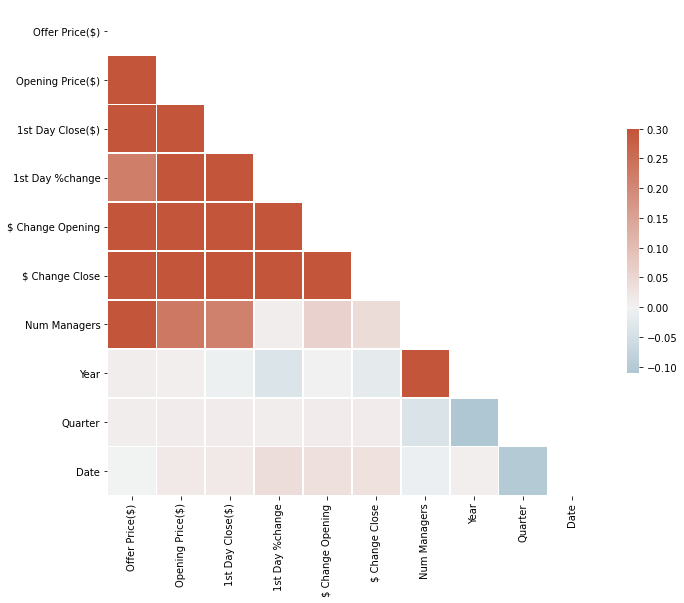

In [819]:
corr = ipo_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In general, high correlation is defined by a value of greater than or equal to 0.9. Here, we can see he maxiumum correlation index is only 0.3, hence, none of the variables are highly correlated. 

Though not a high correlation index, we still see a good level of correlation between the pricing variables and number of managers.

# Section 2: Company Data

The IPO scoop has information about the company only for recent IPOs (that were filed in the past 12 months). Hence, we will investigate the influence of company's features only for the recent IPOs. 

In [820]:
ipo_ls_url = 'https://www.iposcoop.com/last-12-months/'

html = requests.get(ipo_ls_url).content

ipo_ls = pd.read_html(html)
company_df = ipo_ls[-1]
company_df.head(2)

,Company,Symbol,Industry,Offer Date,Shares (millions),Offer Price,1st Day Close,Current Price,Return,SCOOP Rating
0,Expion360 Inc.,XPON,Industrials,4/1/2022,2.2,$7.00,$0.00,$0.00,0.00%,S/O
1,"AN2 Therapeutics, Inc.",ANTX,Health Care,3/25/2022,4.6,$15.00,$15.40,$15.07,0.47%,S/O


Each company name in the above table has a hyperlink associated with it. This hyperlink redirects to the company information website on IPO Scoop. Hence, we will fetch a list of these hyperlinks and append it as a column to this table, and then query this link to extract the company information (such as age, market cap, etc.)

In [821]:
page = requests.get(ipo_ls_url).content
html = BeautifulSoup(page, 'html.parser')
table = html.find('table')
links = table.findAll('a')
company_info_links = links[0::4]

company_info_links = [re.findall('"([^"]*)"', str(x))[0] for x in company_info_links]
company_info_links = pd.DataFrame(company_info_links, columns=['Company_info_link'])
company_df = pd.concat([company_df, company_info_links], axis=1)
company_df.head(2)

,Company,Symbol,Industry,Offer Date,Shares (millions),Offer Price,1st Day Close,Current Price,Return,SCOOP Rating,Company_info_link
0,Expion360 Inc.,XPON,Industrials,4/1/2022,2.2,$7.00,$0.00,$0.00,0.00%,S/O,https://www.iposcoop.com/ipo/expion360-inc/
1,"AN2 Therapeutics, Inc.",ANTX,Health Care,3/25/2022,4.6,$15.00,$15.40,$15.07,0.47%,S/O,https://www.iposcoop.com/ipo/an2-therapeutics-...


In [822]:
def get_company_info(company_info_link, similar_words):
    
    
    result = dict.fromkeys(['Num_Employees', 'Age', 'Profit_Margin(million$)', 'Exchange', 
                  'Price_Range', 'Est_Volume(million$)'])
    
    html = requests.get(company_info_link).content
    try:
        company_info_ls = pd.read_html(html)
    except:
        for i in result.keys():
            result[i] = np.nan
        return result
    
    company_info = company_info_ls[-1]
    company_info.rename(columns={company_info.columns[0]:'title', company_info.columns[1]:'value'}, inplace=True)
    company_info = company_info.T
    company_info.columns = company_info.iloc[0]
    company_info = company_info[1:]
    
    
    company_founded_year = company_info['Founded:'][0]
    if(pd.isnull(company_founded_year)==False):
        founded_year = int(company_founded_year)
        curr_year = int(datetime.date.today().strftime("%Y"))
        company_age = curr_year-founded_year
    else:
        company_age = np.nan
    
    price_range = company_info['Price range'][0]
    price_range = price_range.split('-')
    min_price = price_range[0].strip()[1:]
    max_price = price_range[1].strip()[1:]
    price_range = float(max_price)-float(min_price)
    
    market_cap = company_info['Market Cap'][0]
    if(pd.isnull(market_cap)==False):
        market_cap = market_cap[1:len(market_cap)-3] # to change it from '$100.0mil' to '100.0'
        market_cap = np.nan if market_cap=='' else float(market_cap)
        
    net_income = company_info['Net Income'][0]
    if(pd.isnull(net_income)==False):
        net_income = net_income.split()[0][1:] # to change it from '$39.9 mil (last 12 months)' to '39.9' 
        net_income = np.nan if net_income=='' else float(net_income)

    est_vol = company_info['Est. $ Volume'][0]
    if(pd.isnull(est_vol)==False):
        est_vol = float(est_vol.split()[0][1:]) # to change it from '$16.0 mil' to '16.0'
            
    revenue = company_info['Revenues'][0]
    if(pd.isnull(revenue)==False):
        revenue = revenue.split()[0][1:] # to change it from '$39.9 mil (last 12 months)' to '39.9' 
        revenue = np.nan if revenue=='' else float(revenue)
    
    manager1 = str(company_info['Manager / Joint Managers'][0]).split('/')
    manager2 = str(company_info['CO-Managers'][0]).split('/')
    temp_ls = manager1 + manager2
    
    temp_ls = ' '.join(x for x in temp_ls)
    manager_ls = temp_ls.split()
    manager = clean_map_mgr_names(manager_ls, similar_words)

    profit_margin = np.nan
    if((pd.isna(revenue)==False) and (pd.isna(net_income)==False) and (revenue!=0)):
        profit_margin = net_income/revenue
    
    result['Num_Employees'] = company_info['Employees:'][0] # Number of employees
    result['Age'] = company_age # Age of the company
    result['Revenue(million$)'] = revenue
    result['Market_Cap(million$)'] = market_cap
    result['Exchange'] = company_info['Exchange'][0]
    result['Price_Range'] = price_range
    result['Est_Volume(million$)'] = est_vol
    result['Profit_Margin(million$)'] = profit_margin
    result['Managers'] = manager
    
    return result

In [823]:
%%time
company_info_ls = list(map(lambda x:get_company_info(x, similar_words), company_df['Company_info_link']))

CPU times: user 9.13 s, sys: 263 ms, total: 9.39 s
Wall time: 6min 38s


In [824]:
company_df2 = pd.DataFrame(company_info_ls)
company_df = pd.concat([company_df, company_df2], axis=1)
company_df.shape

(339, 20)

In [825]:
company_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Company                  339 non-null    object 
 1   Symbol                   339 non-null    object 
 2   Industry                 339 non-null    object 
 3   Offer Date               339 non-null    object 
 4   Shares (millions)        339 non-null    float64
 5   Offer Price              339 non-null    object 
 6   1st Day Close            339 non-null    object 
 7   Current Price            339 non-null    object 
 8   Return                   339 non-null    object 
 9   SCOOP Rating             339 non-null    object 
 10  Company_info_link        339 non-null    object 
 11  Num_Employees            326 non-null    object 
 12  Age                      335 non-null    float64
 13  Profit_Margin(million$)  243 non-null    float64
 14  Exchange                 3

**Data Description**

1. Company: Company name
2. Symbol: Company index on stock market
3. Industry: The industry in which the company operates
4. Offer Date: IPO launch date
5. Shares (millions): Number of shares sold in the IPO
6. Offer Price: Initial pricing of the IPO (for 1 stock)
7. Current Price: Current price of the stock
8. Return: Returns based on current price
9. SCOOP Rating: Predicted score (on a scale of 1 to 5) given by IPO Scoop for the performance of the stock before IPO
10. Company_info_link: Link to the company information webpage on the IPO Scoop website
11. Num_Employees: Number of employees at the time of IPO
12. Age: Age of the company (since the time it was founded), at the time of IPO
13. Net Income(million\\$): Net income of the company in the last 12 months before the IPO
14. Exchange: The stock exchange where the IPO was launched
15. Num_Shares(million): Number of shares sold in the IPO
16. Price_Range: The range within which the company had announced that it will price its IPO
17. Est_Volume(million\\$): Estimated volume of shares sold in the IPO
18. Market_Cap(million\\$): The market cap (value) of the company during the IPO

## Data cleaning

- **Step 1: Identify and handle NULL values**
- **Step 2: Defining the correct data type of the columns**
- **Step 3: Extracting company performance information** 
    - %Company sold = IPO size as a proportion of the Market Cap
        - It may be seen as an indicator of the company's confidence in the business
- **Step 4: Extracting time information from the 'Offer Date' column** 
    - Year, month, quarter, day
- **Step 5: Feature selection**
    - Removing columns not useful for our analysis

### Step 1: Identify and handle NULL values

In [826]:
company_df.isnull().sum()

Company                     0
Symbol                      0
Industry                    0
Offer Date                  0
Shares (millions)           0
Offer Price                 0
1st Day Close               0
Current Price               0
Return                      0
SCOOP Rating                0
Company_info_link           0
Num_Employees              13
Age                         4
Profit_Margin(million$)    96
Exchange                    1
Price_Range                 1
Est_Volume(million$)        1
Revenue(million$)           7
Market_Cap(million$)       15
Managers                    1
dtype: int64

Imputing values for the 'Exchange' column would not be right, and the proportion of rows with null value for 'Exchange' is also low. Hence, we can simply remove these rows.

In [827]:
company_df = company_df[company_df['Exchange'].isnull()==False]

In [828]:
company_df.isnull().sum()

Company                     0
Symbol                      0
Industry                    0
Offer Date                  0
Shares (millions)           0
Offer Price                 0
1st Day Close               0
Current Price               0
Return                      0
SCOOP Rating                0
Company_info_link           0
Num_Employees              12
Age                         3
Profit_Margin(million$)    95
Exchange                    0
Price_Range                 0
Est_Volume(million$)        0
Revenue(million$)           6
Market_Cap(million$)       14
Managers                    0
dtype: int64

For the remaining columns, we impute the values with the column's median. 

In [829]:
company_df['Num_Employees'] = company_df['Num_Employees'].fillna(company_df['Num_Employees'].median())
company_df['Age'] = company_df['Age'].fillna(company_df['Age'].median())
company_df['Profit_Margin(million$)'] = company_df['Profit_Margin(million$)'].fillna(company_df['Profit_Margin(million$)'].median())
company_df['Market_Cap(million$)'] = company_df['Market_Cap(million$)'].fillna(company_df['Market_Cap(million$)'].median())

In [830]:
company_df['Revenue(million$)'] = company_df['Revenue(million$)'].fillna(company_df['Market_Cap(million$)'].median())

In [831]:
company_df.isnull().sum()

Company                    0
Symbol                     0
Industry                   0
Offer Date                 0
Shares (millions)          0
Offer Price                0
1st Day Close              0
Current Price              0
Return                     0
SCOOP Rating               0
Company_info_link          0
Num_Employees              0
Age                        0
Profit_Margin(million$)    0
Exchange                   0
Price_Range                0
Est_Volume(million$)       0
Revenue(million$)          0
Market_Cap(million$)       0
Managers                   0
dtype: int64

### Step 2: Defining the correct data type for the columns

In [832]:
company_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 0 to 338
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Company                  338 non-null    object 
 1   Symbol                   338 non-null    object 
 2   Industry                 338 non-null    object 
 3   Offer Date               338 non-null    object 
 4   Shares (millions)        338 non-null    float64
 5   Offer Price              338 non-null    object 
 6   1st Day Close            338 non-null    object 
 7   Current Price            338 non-null    object 
 8   Return                   338 non-null    object 
 9   SCOOP Rating             338 non-null    object 
 10  Company_info_link        338 non-null    object 
 11  Num_Employees            338 non-null    object 
 12  Age                      338 non-null    float64
 13  Profit_Margin(million$)  338 non-null    float64
 14  Exchange                 3

In [833]:
company_df['Offer Price'] = company_df['Offer Price'].str[1:].astype('float')
company_df['1st Day Close'] = company_df['1st Day Close'].str[1:].astype('float')
company_df['Current Price'] = company_df['Current Price'].str[1:].astype('float')

In [834]:
company_df['Num_Employees'] = company_df['Num_Employees'].astype('int')

In [835]:
company_df['Return'] = company_df['Return'].str[:-1].astype('float')

We will define the data type for 'Offer Date' later, when handling that column

### Step 3: Extracting company performance information

%Company Sold = IPO size as a proportion of the Market Cap = (Num Shares sold*Offer Price)/Market Cap

In general, a high percentage of company sold is seen as an indicator of low confidence of the company in its business.

In [836]:
company_df['%Company_sold'] = company_df.apply(lambda x:(x['Shares (millions)']*x['Offer Price'])/x['Offer Price'], axis=1)

### Step 4: Extracting time information from the 'Offer Date' column

In [837]:
company_df['Offer Date'] = pd.to_datetime(company_df['Offer Date'])
company_df['Year'] = company_df['Offer Date'].dt.strftime("%Y").astype('int')
company_df['Month'] = company_df['Offer Date'].dt.strftime("%b")
company_df['Quarter'] = company_df['Offer Date'].dt.quarter.astype('int')
company_df['Day'] = company_df['Offer Date'].dt.strftime("%A")
company_df['Date'] = company_df['Offer Date'].dt.strftime("%-d").astype('int')

### Step 5: Feature selection

In [838]:
company_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 338 entries, 0 to 338
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Company                  338 non-null    object        
 1   Symbol                   338 non-null    object        
 2   Industry                 338 non-null    object        
 3   Offer Date               338 non-null    datetime64[ns]
 4   Shares (millions)        338 non-null    float64       
 5   Offer Price              338 non-null    float64       
 6   1st Day Close            338 non-null    float64       
 7   Current Price            338 non-null    float64       
 8   Return                   338 non-null    float64       
 9   SCOOP Rating             338 non-null    object        
 10  Company_info_link        338 non-null    object        
 11  Num_Employees            338 non-null    int64         
 12  Age                      338 non-nul

We can directly remove few columns that do not contribute any useful information for our analysis:

    - Symbol
    - Current Price (as our analysis is only based on the 1st day IPO performance)
    - SCOOP Rating
    - Company_info_link

In [839]:
company_df.drop(columns=['Current Price','SCOOP Rating', 'Company_info_link'], inplace=True)

Correlation matrix to identify the presence of multi-collinearity (if any)

<AxesSubplot:>

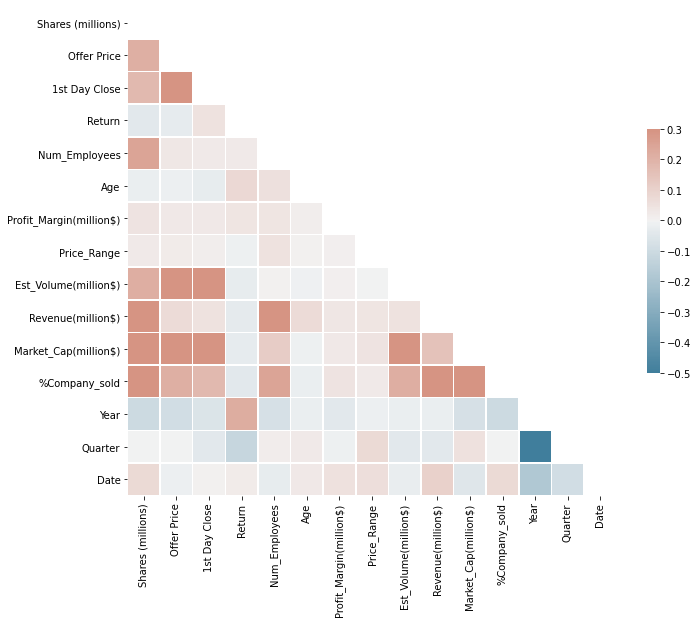

In [840]:
corr = company_df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

The absolute value of the correlation index does not exceed beyond 0.5. Hence, we can confirm that none of the variables are highly correlated. 

# Section 3: Social Trend Data

Information about the social trends around the time of IPO has been fetched from google trends api. We obtain the search volume for a company (keyword=name of the company) all over the world, one month before the IPO launch date, in order to gauge the popularity for the company's stocks in the market. 

Since Google Trends returns only relative values (in the range of 0-100) in a single query, and there are also limits to how many queries that can be placed. Hence, we filter companies by their launch date, and search for the relative search volume for all these companies before their launch (to show how popular one IPO was in relation to another launching on the same day). 

The Google Trends API may not contain data for less-famous companies, and hence, may return null value for such companies. Sometimes the search volume is very low and in such cases, Google Trends just returns 0.

In [841]:
from dateutil.relativedelta import relativedelta
import pytrends
from pytrends.request import TrendReq


pytrends = TrendReq(hl='en-US', tz=360)

ipo_dates = list(set(company_df['Offer Date']))
company_trends = {}

stop_words = ['inc', 'co', 'ltd', 'corp']
for date in ipo_dates:

    date_12m_before = date + relativedelta(months=-1)
    start_day = date_12m_before.day
    start_month = date_12m_before.month
    start_year = date_12m_before.year
    
    end_day = date.day
    end_month = date.month
    end_year = date.year
    
    filter_df = list(company_df[company_df['Offer Date']==date]['Company'])
    companies = [re.sub('([\(\[]).*?([\)\]])', '', x.lower()) for x in filter_df]
    companies_kw = []
    for i in companies:
        i = re.sub('[\.,]', '', i)
        i = [x for x in i.split() if x not in stop_words]
        
        companies_kw.append(i)
    
    historicaldf = pytrends.get_historical_interest(companies_kw, 
                                               year_start=start_year, 
                                               month_start=start_month, 
                                               day_start=start_day, 
                                               hour_start=0, 
                                               year_end=end_year, 
                                               month_end=end_month, 
                                               day_end=end_day, hour_end=0, cat=0, geo='', gprop='', sleep=0)
    for (index, i) in enumerate(companies):
        org_company = filter_df[index]
        try:
            avg_search = historicaldf[i].mean()
            company_trends[org_company] = avg_search
        except:
            company_trends[org_company] = np.nan

In [843]:
company_trends_df = pd.DataFrame(company_trends.items())
company_trends_df.rename(columns={company_trends_df.columns[0]:'Company', company_trends_df.columns[1]:'popularity'}, inplace=True)

In [844]:
company_trends_df['popularity'] = company_trends_df['popularity'].fillna(0)

In [845]:
temp = company_df
temp['Company'] = temp['Company'].str.lower()
company_df2 = pd.merge(company_trends_df, temp, on="Company", how="inner")

# Section 4: Data Exploration

We now have 3 sets of data:
- ipo_df: IPO data
- manager_exp_df: Vectorized information about the managers involved in each IPO
- company_df: Company data

The ipo_df is based on IPOs launched between 2000-2020.
All the other dataframes are based on IPOs launched in the last 12 months.

In [846]:
ipo_df['1st Day %change'].describe()

count    3603.000000
mean       13.670621
std        28.686637
min       -41.080000
25%         0.000000
50%         3.890000
75%        19.805000
max       353.850000
Name: 1st Day %change, dtype: float64

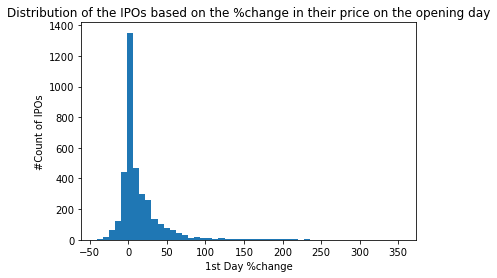

In [847]:
(n, bins, patches) = plt.hist(ipo_df['1st Day %change'], bins=50, label='hst')
plt.xlabel('1st Day %change')
plt.ylabel('#Count of IPOs')
plt.title('Distribution of the IPOs based on the %change in their price on the opening day')
plt.show()

In [848]:
returns_df = pd.DataFrame(list(zip(bins, n)))
returns_df.rename(columns={returns_df.columns[0]:'Bin', returns_df.columns[1]:'#IPOs'}, inplace=True)

In [849]:
returns_df

,Bin,#IPOs
0,-41.0800,6.0
1,-33.1814,17.0
2,-25.2828,61.0
3,-17.3842,123.0
4,-9.4856,445.0
5,-1.5870,1351.0
6,6.3116,468.0
7,14.2102,296.0
8,22.1088,258.0
9,30.0074,136.0


The majority of the IPOs (1351, which is approx 38% of the dataset) have %returns between -1.5870 and 6.3116. 

There are also many outliers making exceptionally large returns (like one company making 345% returns on 1st day!). We need to make note of these outliers when we perform multivariate analysis.

In [850]:
num_less = returns_df[returns_df['Bin']<-1.5870]['#IPOs'].sum()
num_more = returns_df[returns_df['Bin']>6.3116]['#IPOs'].sum()
total = ipo_df.shape[0]
print("Number of IPOs with %returns less than -1.5870: " + str(num_less) + " (= approx " + str(round((num_less/total)*100, 1)) + "%) of the dataset")
print("Number of IPOs with %returns more than 6.3116: " + str(num_more) + " (= approx " + str(round((num_more/total)*100, 1)) + "%) of the dataset")

Number of IPOs with %returns less than -1.5870: 652.0 (= approx 18.1%) of the dataset
Number of IPOs with %returns more than 6.3116: 1132.0 (= approx 31.4%) of the dataset


In [851]:
ipo_df['1st Day %change'].describe()

count    3603.000000
mean       13.670621
std        28.686637
min       -41.080000
25%         0.000000
50%         3.890000
75%        19.805000
max       353.850000
Name: 1st Day %change, dtype: float64

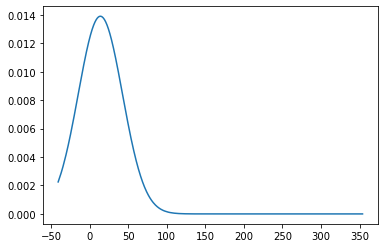

In [852]:
mu = statistics.mean(ipo_df['1st Day %change'])
sigma = statistics.stdev(ipo_df['1st Day %change'])
x = ipo_df['1st Day %change'].sort_values(ascending=True)
plt.plot(x, norm.pdf(x, mu, sigma))
plt.show()

**95% Confidence Interval for IPO investments**

In [853]:
print("Lower bound of 95% CI: " + str(round(mu - (1.96*sigma), 3)))

Lower bound of 95% CI: -42.555


In [854]:
print("Uppwer bound of 95% CI: " + str(round(mu + (1.96*sigma), 3)))

Uppwer bound of 95% CI: 69.896


The distribution of returns is skewed to the right, with a long tail. Based on the historic data, we know that 95% of the time IPO investment would yield returns in the range between [-42%, 70%]. 

In [855]:
from scipy.stats import norm
norm(mu, sigma).cdf(0)- norm(mu, sigma).cdf(mu-(2*sigma))

0.29409111317681913

The probability of downside risk (i.e. making loss) in an IPO investment is: 29% (at a 95% confidence level)

**95% Confidence Interval based on Manager as a driver to determine the downside risk**

In [856]:
managers_ls = set(itertools.chain.from_iterable(list(ipo_df['Lead/Joint Lead Managers'])))

In [857]:
multiple_ipo_managers = [x for x in manager_num_ipos if manager_num_ipos[x] > 7]

In [858]:
manager_risk = {}

for manager in multiple_ipo_managers:
    filtered_df = ipo_df[ipo_df['Lead/Joint Lead Managers'].map(set([manager]).issubset)]
    mu = statistics.mean(filtered_df['1st Day %change'])
    sigma = statistics.stdev(filtered_df['1st Day %change'])
    risk_prob = norm(mu, sigma).cdf(0) - norm(mu, sigma).cdf(mu-(2*sigma))
    manager_risk[manager] = risk_prob 

In [859]:
manager_risk = dict(sorted(manager_risk.items(), key=lambda item: item[1], reverse=True))
medium_risk_managers = [[x, manager_risk[x]] for x in manager_risk if manager_risk[x]>0.294]
high_risk_managers = [[x, manager_risk[x]] for x in manager_risk if manager_risk[x]>0.5]

In [860]:
print("Medium risk managers: ")
medium_risk_managers

Medium risk managers: 


[['I-Bankers Securities', 0.597725205237137],
 ['Aegis Capital Corp', 0.5550098248835001],
 ['Wunderlich Securities', 0.5474025893657777],
 ['BTIG', 0.5178059668624468],
 ['Rodman & Renshaw', 0.508991465637923],
 ['Maxim Group LLC', 0.5080571162104195],
 ['Paulson Investment', 0.5021368928060069],
 ['Cantor Fitzgerald & Co', 0.4952414188844294],
 ['Ladenberg Thalmann', 0.45944129148261764],
 ['WR Hambrecht+Co', 0.45096886874952774],
 ['EarlyBirdCapital, Inc', 0.4409352265855503],
 ['Joseph Gunnar & Co', 0.43263331932102983],
 ['Chardan Capital Markets', 0.42382179276935195],
 ['Oppenheimer & Co', 0.39232205076373794],
 ['JMP Securities', 0.38916363729561837],
 ['ING', 0.3642724405519876],
 ['Feltl & Company', 0.3592353843000813],
 ['FBR Capital Markets', 0.34560751478599305],
 ['SunTrust Robinson Humphrey', 0.3327343651458065],
 ['Macquarie Capital', 0.32971281591560436],
 ['I-Bankers', 0.3232152850972354],
 ['Mizuho Securities', 0.3227319534342547],
 ['Stifel', 0.321896951475259],
 ['

In [861]:
print("High risk managers")
high_risk_managers

High risk managers


[['I-Bankers Securities', 0.597725205237137],
 ['Aegis Capital Corp', 0.5550098248835001],
 ['Wunderlich Securities', 0.5474025893657777],
 ['BTIG', 0.5178059668624468],
 ['Rodman & Renshaw', 0.508991465637923],
 ['Maxim Group LLC', 0.5080571162104195],
 ['Paulson Investment', 0.5021368928060069]]

The high risk managers have more than 50% chance (with 95% confidence) to yield negative returns. Hence, a potential investor may choose to avoid IPOs handled by them.

**Analysis by Industry**

In [862]:
industry_list = list(company_df['Industry'])

In [863]:
num_ipos_industry = company_df['Industry'].value_counts()
num_ipos_industry = pd.DataFrame(num_ipos_industry)
num_ipos_industry = num_ipos_industry.reset_index(level=0)
num_ipos_industry.rename(columns={'index':'Industry', 'Industry':'Count'}, inplace=True)

In [864]:
num_ipos_industry

,Industry,Count
0,Health Care,113
1,Technology,98
2,Consumer Goods,31
3,Financials,24
4,Consumer Services,24
5,Blank Check,23
6,Industrials,16
7,Other,5
8,Oil & Gas,2
9,Basic Materials,1


In [865]:
company_df['1st Day %change'] = company_df.apply(lambda x:float(x['Return']/x['Offer Price']), axis=1)

In [866]:
industry_list = num_ipos_industry[num_ipos_industry.Count>5].Industry
industry_risk = {}
industry_returns = {}

for industry in industry_list:
    filtered_df = company_df[company_df['Industry']==industry]
    mu = statistics.mean(filtered_df['1st Day %change'])
    sigma = statistics.stdev(filtered_df['1st Day %change'])
    returns = statistics.mean(filtered_df['Return'])
    risk_prob = norm(mu, sigma).cdf(0) - norm(mu, sigma).cdf(mu-(2*sigma))
    industry_risk[industry] = risk_prob 
    industry_returns[industry] = returns

In [867]:
industry_returns_risk = pd.DataFrame(industry_risk.items(), industry_returns.items())
industry_returns_risk = industry_returns_risk.reset_index(level=-1)
industry_returns_risk.rename(columns={industry_returns_risk.columns[0]:'Risk', industry_returns_risk.columns[1]:'Industry', industry_returns_risk.columns[2]:'Returns'}, inplace=True)

In [868]:
fig = px.scatter(industry_returns_risk, x='Returns', y='Risk', color='Industry', title="Risk vs Returns by Industry")
fig.show()

In [869]:
# industry_risk = dict(sorted(industry_risk.items(), key=lambda item: item[1], reverse=True))
# industry_risk

In [870]:
# fig = px.scatter(ipo_df, x='1st Day %change', y='risk', color='manager')
# fig.show()

**Analysis by Manager**

In [871]:
manager_returns_mu = {}
manager_returns_sigma = {}
for manager in multiple_ipo_managers:
    filtered_df = ipo_df[ipo_df['Lead/Joint Lead Managers'].map(set([manager]).issubset)]
    returns_mu = statistics.mean(filtered_df['1st Day %change'])
    manager_returns_mu[manager] = returns_mu
    returns_sigma = statistics.stdev(filtered_df['1st Day %change'])
    manager_returns_sigma[manager] = returns_sigma

In [872]:
manager_returns_mu = dict(sorted(manager_returns_mu.items(), key=lambda item: item[1], reverse=True))
print('Ranking managers by the avg return of their IPOs:')
manager_returns_mu

Ranking managers by the avg return of their IPOs:


{'Robertson Stephens': 47.63928571428571,
 'ViewTrade Securities': 45.38,
 'KeyBanc Capital Market': 43.60666666666667,
 'Allen & Company': 42.4148,
 'Guggenheim Securities': 37.75,
 'Chase H&Q': 30.08888888888889,
 'DeutscheBanc Alex. Brown': 21.7175,
 'Goldman Sachs Japan': 20.96412017167382,
 'Mizuho Securities': 19.865833333333335,
 'Banc of America': 19.54991379310345,
 'Wm Blair': 19.243492063492063,
 'Thomas Weisel': 19.173928571428572,
 'SG Cowen': 19.012857142857143,
 'Morgan Stanlet Dean Witter': 18.41868148148148,
 'Salomon Smith Barney': 17.64302564102564,
 'UBS Securitie': 17.521176470588234,
 'Leerink Partners': 17.503425925925924,
 'Piper Sandler': 17.317,
 'Jefferirs': 17.05672932330827,
 'UBS Warburg': 16.792380952380952,
 'Evercore ISI': 16.362121212121213,
 'J.P.Morgan': 16.184458015267175,
 'Credit Suisse First Boston': 15.98080895008606,
 'Donaldson, Lufkin & Jenrette': 15.940000000000001,
 'Cohen & Company Capital Markets, LLC': 15.397533333333334,
 'SunTrust Robi

In [873]:
manager_returns_sigma = dict(sorted(manager_returns_sigma.items(), key=lambda item: item[1], reverse=True))
print("Ranking managers by the std deviation of the risk (loss) of their IPOs:")
manager_returns_sigma

Ranking managers by the std deviation of the risk (loss) of their IPOs:


{'KeyBanc Capital Market': 66.99812488491926,
 'Chase H&Q': 61.89394210487037,
 'Mizuho Securities': 49.97103678556452,
 'Robertson Stephens': 47.83925978078702,
 'SunTrust Robinson Humphrey': 40.02104804920183,
 'Banc of America': 38.19309353673184,
 'Goldman Sachs Japan': 37.156774049760635,
 'ViewTrade Securities': 37.10838488228003,
 'Evercore ISI': 35.458623841526176,
 'Allen & Company': 35.08990502029513,
 'Stifel': 34.27885295004093,
 'Jefferirs': 33.94930433913725,
 'Leerink Partners': 33.77462073673588,
 'Credit Suisse First Boston': 33.453908686630875,
 'Salomon Smith Barney': 32.31255680926467,
 'Guggenheim Securities': 32.105069915602336,
 'Cohen & Company Capital Markets, LLC': 30.891754116563376,
 'UBS Securitie': 29.596254594617406,
 'Morgan Stanlet Dean Witter': 29.413220395182947,
 'SG Cowen': 29.07809750477762,
 'Barclay Capital': 27.97089672732186,
 'BofA Merrill Lynch': 27.31346047390947,
 'J.P.Morgan': 26.715183034382218,
 'RBC Capital Markets': 26.54494849587874,


In [874]:
df = pd.DataFrame({'manager':multiple_ipo_managers, 'returns':0, 'risk':0})
df['returns'] = df.apply(lambda x:manager_returns_mu[x['manager']], axis=1)
df['risk'] = df.apply(lambda x:manager_returns_sigma[x['manager']], axis=1)

In [875]:
!pip install plotly

In [876]:
fig = px.scatter(df, x='returns', y='risk', color='manager', title="Risk vs Returns by Manager")
fig.show()

**Analysis by popularity**

In [879]:
company_df2['1st Day %change'] = company_df2.apply(lambda x:float(x['Return']/x['Offer Price']), axis=1)

In [880]:
x = company_df2.sort_values(by=['popularity'])
x = pd.DataFrame(x.groupby('popularity')['1st Day %change'].mean())
x.reset_index(level=-1, inplace=True)

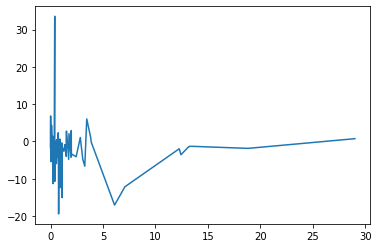

In [881]:
plt.plot(x['popularity'], x['1st Day %change'])
plt.show()

We can see that there is no correlation between the popularity index and returns before popularity index<6. This maybe due to 2 reasons:
    - For companies that had very low search volume or those that were not detected by Google Trends api, the default value is 0. Hence, the huge surge of IPOs with popularity=0.
    - The relation between the popularity index and avg returns is clearly defined only for companies with popularity index>6. 

# SECTION 5: Model Training and Evaluation

We will use the most recent 12 months data to build and test our model, as we have company information only for this data. 

**We will be building a classifier model, which predicts the score/ranking of an IPO**

The ranking of the IPO is defined the following way (logic borrowed from external sources like IPO Scoop):

- Rank 1: $0 - $0.49 per share
- Rank 2: $0.5 - $1 per share
- Rank 3: $1 - $3 per share
- Rank 4: $4 or more (but less than the double of the Offer Price), per share
- Rank 5: Double of the offer price or more, per share


Step 1: Add 'Score' variable to our dataset

Step 2: Removing columns that would not be available for new IPOs (e.g. '1st Day Close') before the launch date. Our main goal is to predict the performance of IPOs, hence, we will only use variables that can be obtained before the IPO launch, in our model.

Step 3: Handling categorical variables

Step 4: Checking the distribution of our class variable

   - Imbalanced dataset would make the model biased, hence, depending on the distribution of our class variable, we need to oversample/undersample our dataset so that we have uniform distribution of all classes.

Step 5: Model Training

- We will train the following models and then choose the best amongst them for our analysis:

    - Random Forest
    - Naive Bayes
    - SVM
    - Gradient Boosting Tree

- We will perform cross-validation as we have a relatively small dataset (only 300+ rows)

Step 6: Model Evaluation and Selection

- We will use RMSE and R-squared values to evaluate the model. RMSE will indicate the accuracy of the model and R-squared value would indicate the fit of the model (how much it is able to explain the variances observed in the outcome variable).

Step 7: Interpreting the results

**Step 1: Add 'Score' variable to the dataset**

In [882]:
company_df3 = company_df2

def score_ipo(close_price, offer_price):
    profit = close_price - offer_price
    score = 0
    if(profit>=(2*offer_price)):
        score = 5
    elif(profit<=0.49):
        score = 1
    elif((profit>=0.5) and (profit<1)):
        score = 2
    elif((profit>=1) and (profit<=3)):
        score = 3
    else:
        score = 4
    return score

company_df3['Score'] = company_df3.apply(lambda x:score_ipo(x['1st Day Close'], x['Offer Price']), axis=1)

**Step 2: Remove variables that would not be available for new IPOs (not yet launched)** 

In [883]:
company_df3 = company_df3.drop(['1st Day %change', '1st Day Close', 'Return'], axis=1)

We can also remove some other variables that do not contribute much information to the model

In [884]:
company_df3.drop(['Company', 'Symbol', 'Offer Date', 'Year', 'Date', 'Month', 'Quarter', 'Day'], axis=1, inplace=True)

**Step 3: Handling Categorical variables**

One-hot encoding for all categorical variables (Except manager name):

In [885]:
temp_df = pd.get_dummies(company_df3[['Industry', 'Exchange']], prefix=['Industry', 'Exchange'])
company_df3.drop(['Industry', 'Exchange'], axis=1, inplace=True)
company_df3 = pd.concat([company_df3, temp_df], axis=1)

Vectorizing manager name (similar to one-hot encoding, as it just indicates the presence of a specific manager in an IPO with 0/1 value)

In [886]:
vectorizer = CountVectorizer(analyzer=lambda x:x)
X = vectorizer.fit_transform(company_df3['Managers']).toarray()
manager_col_names = vectorizer.get_feature_names()
manager_df = pd.DataFrame(X, columns=manager_col_names)

company_df3 = pd.concat([company_df3, manager_df], axis=1)
company_df3.drop(['Managers'], axis=1, inplace=True)

**Step 4: Checking the distribution of the class variable 'Score'**

(array([143.,   0.,  16.,   0.,   0.,  47.,   0., 109.,   0.,   8.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

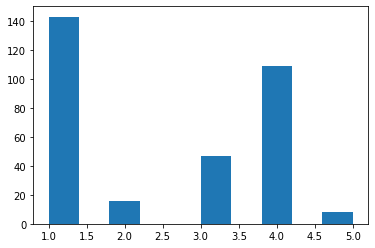

In [887]:
plt.hist(company_df2['Score'])

The data is clearly imbalanced, with IPOs having rating=1 and 4 having exceptionally high number of records than the other classes. This would make the model biased. Hence, we need to over-sample the minority classes in order to balance this dataset. We use the SMOTE method to over-sample the dataset.

In [945]:
X = company_df3.drop(['Score'], axis=1)
y = company_df3['Score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [946]:
import imblearn
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

The distribution is highly imbalanced. It contains many outliers, which need to be removed. Since our data is skewed, we use the IQR approach to detect and remove the outliers.

(array([116.,   0., 116.,   0.,   0., 116.,   0., 116.,   0., 116.]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. ]),
 <BarContainer object of 10 artists>)

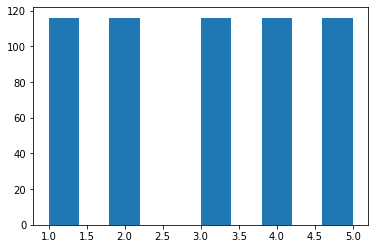

In [947]:
plt.hist(y_train)

The data is now balanced and we have equal number of records for all classes/scores.

**Step 5: Normalization**

In [948]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

In [949]:
sc = StandardScaler()
# from sklearn import preprocessing

# sc = preprocessing.MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [950]:
pca = PCA(n_components=150)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

**Step 5: Model Training**

*Model 1: Random Forest*

In [951]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators = 1000, random_state = 42)
cv = KFold(n_splits=5, random_state=42, shuffle=True)
n_scores = cross_validate(rf_model, X_train, y_train, scoring='accuracy' , cv=cv, n_jobs=-1, error_score='raise')

In [952]:
print('Accuracy (train data): ' + str(round(mean(n_scores['test_score']), 2)))

Accuracy (train data): 0.47


*Model 2: Naive Bayes*

In [953]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
cv = KFold(n_splits=5, random_state=42, shuffle=True)
n_scores = cross_validate(gnb, X_train, y_train, scoring='accuracy' , cv=cv, n_jobs=-1, error_score='raise')

In [954]:
print('Accuracy (train data): ' + str(round(mean(n_scores['test_score']), 2)))

Accuracy (train data): 0.38


*Model 3: SVM*

In [955]:
from sklearn.svm import SVC
svc = SVC(gamma='auto')
cv = KFold(n_splits=5, random_state=42, shuffle=True)
n_scores = cross_validate(svc, X_train, y_train, scoring='accuracy' , cv=cv, n_jobs=-1, error_score='raise')

In [956]:
print('Accuracy (train data): ' + str(round(mean(n_scores['test_score']), 2)))

Accuracy (train data): 0.51


*Model 4: Gradient Boosting Tree*

In [957]:
import xgboost as xgb
xgb_reg = xgb.XGBClassifier()
cv = KFold(n_splits=5, random_state=42, shuffle=True)
n_scores = cross_validate(xgb_reg, X_train, y_train, scoring='accuracy' , cv=cv, n_jobs=-1, error_score='raise')

In [958]:
print('Accuracy (train data): ' + str(round(mean(n_scores['test_score']), 2)))

Accuracy (train data): 0.42


**Step 6: Model Evaluation and selection**

We choose the SVM model as it has the highest accuracy.

In [959]:
model = SVC(gamma='auto')
model = model.fit(X_train, y_train)

In [960]:
y_pred = model.predict(X_test)

In [961]:
cm = confusion_matrix(y_test, y_pred)

In [962]:
cm

array([[23,  0,  0,  3,  1],
       [ 5,  0,  0,  0,  0],
       [ 8,  0,  0,  3,  1],
       [13,  0,  0,  8,  0],
       [ 0,  0,  0,  0,  0]])

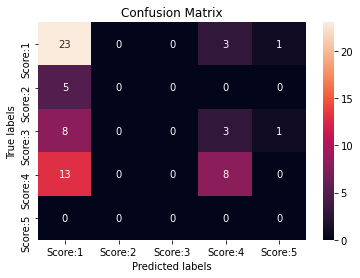

In [963]:
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Score:1', 'Score:2', 'Score:3', 'Score:4', 'Score:5']); ax.yaxis.set_ticklabels(['Score:1', 'Score:2', 'Score:3', 'Score:4', 'Score:5']);


Observations for the test data predictions:
- Only Score=1, 4 and 5 classes have records being predicted correctly
- Most of the records get classified under Score=1 or 13

In [966]:
accuracy = (cm.diagonal().sum())/len(y_test)
print("Accuracy (test data): " + str(accuracy))

Accuracy (test data): 0.47692307692307695
